3DDiff file using Monterey and Eel canyons' profiles
================================================================

Set values of diffusivity within canyon using the no-canyon grid and the mean diffusivity profiles of Monterey and Eel canyons (/ocean/kramosu/Data/Diffusivity_profiles_Eel_and_Monterey.ipynb).

Files are:

* /ocean/kramosmu/Data/mean_kp_Monterey.csv 
* /ocean/kramosmu/Data/mean_kp_Eel.csv




In [34]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import seaborn as sns
import struct

In [35]:
import canyon_tools.readout_tools as rout

### Functions

In [72]:
def read_kvCSV(filename):
    '''Read in csv file "filename" with kp mean profiles and return diffusivity and depth'''
    df = pd.read_csv(filename)
    kv = df['kp']
    dep = df['depth']
    return (kv, dep)

#------------------------------------------------------------------------------------------------------------------------
def smooth_3D_diff(kv_array, W=13000, kbg = 1e-5):
    '''Exponential smoothing of a 3D kv map
    kv_smooth: np array with 3D map of diffusivities
    W: Exponential length scale of decay will be 0.25*W
    kbg: background diffusivity'''
    
    kv_smooth = np.copy(kv_array)
    # Break canyon into 2 sections vertically and horizontally
    xini_h1 = 0
    xfin_h1 = 180
    xini_h2 = 180
    xfin_h2 = 615
    yini_h1 = 0
    yfin_h1 = 75
    yini_h2 = 267
    yfin_h2 = 359

    # Apply exponential smoothing to each half
    for kk in range(90):
        
        for jj in range(360):
            for ii in range(xini_h2, xfin_h2, 1):
                if np.isnan(kv_array[kk,jj,ii+1]) == True:
                    lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                    k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(X[ii:]-X[ii]))
                    kv_smooth[kk,jj,ii:] = k_sm
                    break

            for ii in range(xfin_h1, xini_h1, -1):
                if np.isnan(kv_array[kk,jj,ii-1]) == True:
                    lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                    k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(-X[:ii]+X[ii]))
                    kv_smooth[kk,jj,:ii] = k_sm
                    break

        for ii in range(616):
            for jj in range(yini_h2, yfin_h2, 1):
                if np.isnan(kv_array[kk,jj+1,ii]) == True:
                    lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                    k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(Y[jj:]-Y[jj]))
                    kv_smooth[kk,jj:,ii] = k_sm
                    break

            for jj in range(yfin_h1, yini_h1, -1):
                if np.isnan(kv_array[kk,jj-1,ii]) == True:
                    lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                    k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(-Y[:jj]+Y[jj]))
                    kv_smooth[kk,:jj,ii] = k_sm
                    break

    kv_final = np.where(np.isnan(kv_smooth)== True , kbg, kv_smooth)
    kv_final = np.where(kv_final < kbg , kbg, kv_final)
    return kv_final

#------------------------------------------------------------------------------------------------------------------------
def build_3D_diff(hFacC, kv_bg, delta, thresh, RC, kv_profile, dep_profile):
    
    kv_array = np.ones(np.shape(hFacC))*kv_bg # Initial kv array
    ind_canyon = np.argwhere(delta > thresh) # horizontal indices of canyon, (y,x)

    ii = 0

    for ind in ind_canyon:

        bot_ind = np.argmin(hFacC[:,ind[0],ind[1]]) # find bottom z-index (first zero in hFacC)

        if bot_ind == 0: # this means hfac=1 through the whole water col
            bot_ind = 89

        interp_z = RC[:bot_ind] # interp to water column above bottom

        F = interp.interp1d(dep_profile*RC[bot_ind], kv_profile, kind='linear', fill_value='extrapolate')
        kv_interp = F(interp_z)

        kv_array[:bot_ind, ind[0], ind[1]] = kv_interp
        ii = ii+1

    return kv_array

#------------------------------------------------------------------------------------------------------------------------
def build_3D_diff_rim(hFacC, kv_bg, delta, thresh, RC, kv_profile, dep_profile):
    
    kv_array = np.ones(np.shape(hFacC))*kv_bg # Initial kv array
    ind_canyon = np.argwhere(delta > thresh) # horizontal indices of canyon, (y,x)

    ii = 0

    for ind in ind_canyon:

        bot_ind = np.argmin(hFacC[:,ind[0],ind[1]]) # find bottom z-index (first zero in hFacC)

        if bot_ind == 0: # this means hfac=1 through the whole water col
            bot_ind = 89

        Z_rim = -depth_Can[ind[0],380]
        interp_z = (RC[:bot_ind]-Z_rim)/(RC[bot_ind]-Z_rim) # interp to water column above bottom
        
        F = interp.interp1d(dep_profile, kv_profile, kind='linear', fill_value='extrapolate')
        kv_interp = F(interp_z)

        kv_array[:bot_ind, ind[0], ind[1]] = kv_interp
        ii = ii+1

    return kv_array

#------------------------------------------------------------------------------------------------------------------------
def final_3D_diff(hFacCcan, kv_bg, delta, thresh, RC, kv_profile, dep_profile, W=13000, kbg = 1e-5, rim_log = False):
    '''make final, smoothed 3D map of diffusivities based on kv_profile'''
    
    if rim_log == True: 
        kv_temp = build_3D_diff_rim(hFacCcan, kv_bg, delta, thresh, RC, kv_profile, dep_profile)
    else:
        kv_temp = build_3D_diff(hFacCcan, kv_bg, delta, thresh, RC, kv_profile, dep_profile)
    
    kv_map = smooth_3D_diff(kv_temp, W, kbg)
    return kv_map

In [82]:
def plot_sections(kv_map, canyon_name):

    masked_logkvsm = np.ma.masked_array(np.log10(kv_map), mask = land_mask)

    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,10.5))

    mesh = ax1.pcolor(Y[:]/1000,RC[:], masked_logkvsm[:,:,180] , vmax=-1, vmin=-6, cmap = cmo.cm.delta)
    cb = plt.colorbar(mesh, ax=ax1)
    cb.set_label(r'log$_{10}$($K_v$ / m$^2$s$^{-1}$)')
    ax1.set_title('Cross-section along canyon axis - %s-like profile' %canyon_name)
    ax1.set_ylabel('m')
    ax1.set_xlabel('km')
    ax1.plot(Y[:]/1000, -depth_Can[:,280], 'k-')

    mesh = ax2.pcolor(X[:]/1000,RC[:], masked_logkvsm[:,227,:], vmax=-1, vmin=-6, cmap = cmo.cm.delta)
    cb = plt.colorbar(mesh, ax=ax2)
    cb.set_label(r'log$_{10}$($K_v$ / m$^2$s$^{-1}$)')
    ax2.set_title('Cross-section along mid-length')
    ax2.set_ylabel('m')
    ax2.set_xlabel('km')
    ax2.set_ylim(-600,0)
    ax2.set_xlim(45,75)

    mesh = ax3.pcolor(X[:]/1000,Y[:]/1000, masked_logkvsm[5,:,:], vmax=-1, vmin=-6, cmap = cmo.cm.delta)
    cb = plt.colorbar(mesh, ax=ax3)
    cb.set_label(r'log$_{10}$($K_v$ / m$^2$s$^{-1}$)')
    ax3.set_title('Top view at depth %1.1f m' % RC[5])
    ax3.set_ylabel('km')
    ax3.set_xlabel('km')
    ax3.set_aspect(1)

    plt.tight_layout()
    
    return(fig, ax1, ax2, ax3)

### Input

In [38]:
#Input 
nx = 616
ny = 360
nz = 90

kv_bg = np.nan
kv_can = 1E-2

filename = "%dx%dx%d/KrDiff_Mty_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename2 = "%dx%dx%d/KrDiff_Eel_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)

filename_rim = "%dx%dx%d/KrDiff_Mty_rim_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename2_rim = "%dx%dx%d/KrDiff_Eel_rim_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)

In [39]:
## Get grid variables

fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run42/gridGlob.nc'
GridOutNoC = Dataset(fileNoC)

fileCan='/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/gridGlob.nc'
GridOut = Dataset(fileCan)

depth_NoC = rout.getField(fileNoC,'Depth')
depth_Can = rout.getField(fileCan,'Depth')

hFacC = rout.getField(fileNoC,'HFacC') #(90,616,360)
hFacCcan = rout.getField(fileCan,'HFacC') #(90,616,360)

land_mask = rout.getMask(fileCan, 'HFacC') 

Y = GridOut.variables['Y']
RC = GridOut.variables['RC']
X = GridOut.variables['X']




### Find canyon indices

In [40]:
# Isolate canyon
thresh = 5.0 # min vertical resolution
delta = depth_Can-depth_NoC
delta_masked = np.ma.masked_less_equal(delta, thresh)
    
print(np.shape(delta))

(360, 616)


Text(0,0.5,'km')

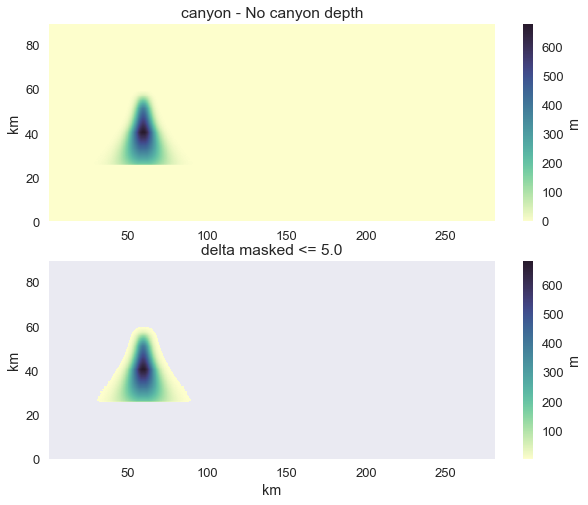

In [41]:
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
mesh = ax1.pcolor(X[:]/1000,Y[:]/1000, delta, cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax1)
cb.set_label('m')
ax1.set_title('canyon - No canyon depth')
ax1.set_ylabel('km')

mesh = ax2.pcolor(X[:]/1000,Y[:]/1000, delta_masked, cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax2)
cb.set_label('m')
ax2.set_title('delta masked <= %1.1f' %thresh)
ax2.set_xlabel('km')
ax2.set_ylabel('km')

### Read in realistic kv profiles

In [42]:
# Read in kp profiles from Monterey and Eel canyons

file_mty = '/ocean/kramosmu/Data/mean_kp_Monterey.csv'
file_eel = '/ocean/kramosmu/Data/mean_kp_Eel.csv'
file_mty_rim = '/ocean/kramosmu/Data/mean_rim_kp_Monterey.csv'
file_eel_rim = '/ocean/kramosmu/Data/mean_rim_kp_Eel.csv'

kv_mty, dep_mty = read_kvCSV(file_mty)
kv_eel, dep_eel = read_kvCSV(file_eel)
kv_mty_rim, dep_mty_rim = read_kvCSV(file_mty_rim)
kv_eel_rim, dep_eel_rim = read_kvCSV(file_eel_rim)


### Find a good interpolation 

- turns out linear is good enough

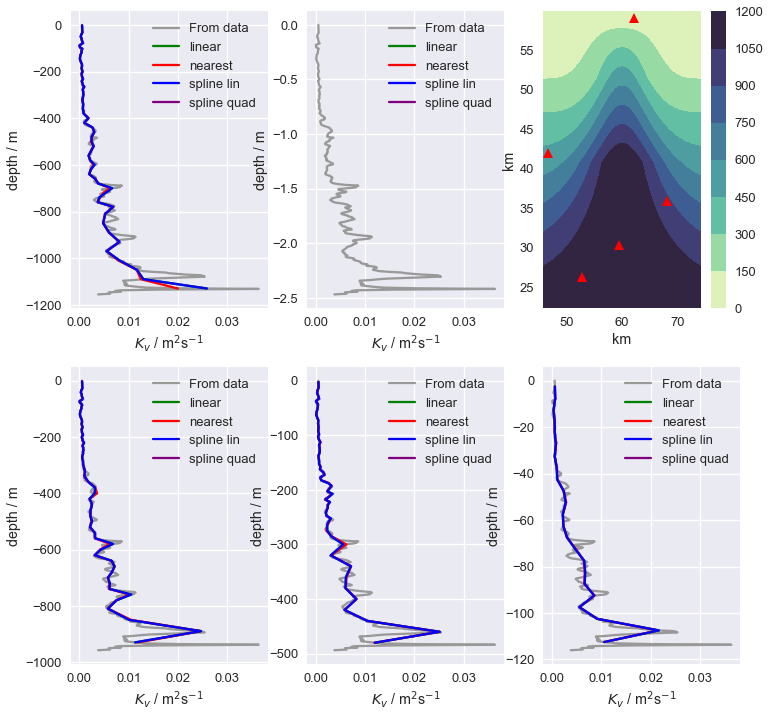

In [43]:
# Which interpolation to use? ---> Linear, it doesn't matter
fig,((ax0,ax1, ax4),(ax2,ax3,ax5)) = plt.subplots(2,3, figsize=(12,12))

mesh = ax4.contourf(X[100:260]/1000,Y[60:270]/1000, depth_Can[60:270,100:260], cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax4)
ax4.set_ylabel('km')
ax4.set_xlabel('km')


ind_canyon = np.argwhere(delta > 0.1) # horizontal indices of canyon, (y,x)
ind_list = [100, 5000, 12000, 20000, 38000] # Choose 5 profiles within the canyon to check

for ind, ax in zip(ind_canyon[ind_list], [ax0,ax1,ax2,ax3,ax5]):
    
    bot_ind = np.argmin(hFacCcan[:,ind[0],ind[1]]) # find bottom z-index (first zero in hFacC)
    interp_z = RC[:bot_ind+1] # interp to water column above bottom
    
    F1 = interp.interp1d(dep_mty*RC[bot_ind], kv_mty,kind='linear', fill_value='extrapolate')
    F2 = interp.interp1d(dep_mty*RC[bot_ind], kv_mty,kind='nearest', fill_value='extrapolate')
    F3 = interp.interp1d(dep_mty*RC[bot_ind], kv_mty,kind='slinear')
    F4 = interp.interp1d(dep_mty*RC[bot_ind], kv_mty,kind='quadratic')
    
    kv_interp1 = F1(interp_z)
    kv_interp2 = F2(interp_z)
    kv_interp3 = F3(interp_z)
    kv_interp4 = F4(interp_z)
    
    ax.plot(kv_mty, dep_mty*RC[bot_ind],  '-', color='0.6', label = 'From data')
    ax.plot(kv_interp1, interp_z,  '-', color='g', label='linear')
    ax.plot(kv_interp2, interp_z,  '-', color='r', label='nearest')
    ax.plot(kv_interp3, interp_z,  '-', color='b', label='spline lin')
    ax.plot(kv_interp4, interp_z,  '-', color='purple', label='spline quad')
    ax.set_ylabel('depth / m')
    ax.set_xlabel('$K_v$ / m$^2$s$^{-1}$')
    ax.legend(loc=0)

    ax4.plot(X[ind[1]]/1000, Y[ind[0]]/1000, '^r')

### Make 3D maps of kv based on realistic profiles

These are smoothed using an exponential decay given by:
    

Decay lengthscale to K_{bg} is  3250.0 m


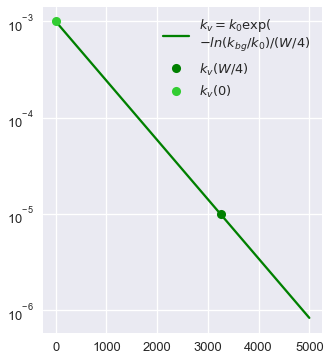

In [44]:
# Find an exponential to smooth out sharp interface 
ko = 1E-3
kbg = 1E-5
W = 13000 # m
lam = -(1/(0.25*W))*np.log(kbg/ko) # decay scale so that at 1/4 of the canyon width the diffusivity is kbg
print('Decay lengthscale to K_{bg} is % 1.1f m' %(0.25*W))

# def exponential
x_vec = np.linspace(0,5000,50)
ksm = ko*np.exp(-lam*x_vec)

# plot
fig, (ax1) = plt.subplots(1,1, figsize=(5,6))
ax1.semilogy(x_vec,ksm, 'g-',label='$k_v=k_0 \exp({$\n$-ln(k_{bg}/k_{0})/(W/4)})$')
ax1.plot(0.25*W, kbg, 'go',label='$k_v(W/4)$' )
ax1.plot(0, ko, 'o',color='limegreen', label='$k_v(0)$')
ax1.legend(loc=0)
plt.show()

In [45]:
kv_final_mty = final_3D_diff(hFacCcan, kv_bg, delta, thresh, RC, kv_mty, dep_mty, W=13000, kbg = 1e-5)
print('done with Monterey')

kv_final_eel = final_3D_diff(hFacCcan, kv_bg, delta, thresh, RC, kv_eel, dep_eel, W=13000, kbg = 1e-5)
print('done with Eel')

done with Monterey
done with Eel


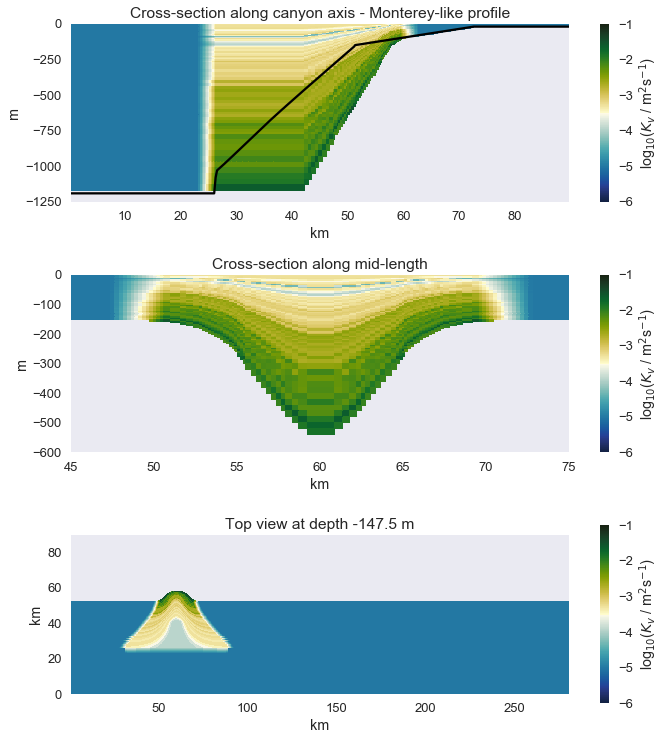

In [46]:
fig, ax1, ax2, ax3 = plot_sections(kv_final_mty, 'Monterey')
#fig.savefig('model_kv_from_Mty.eps', format='eps', bbox_inches='tight', frameon = False)

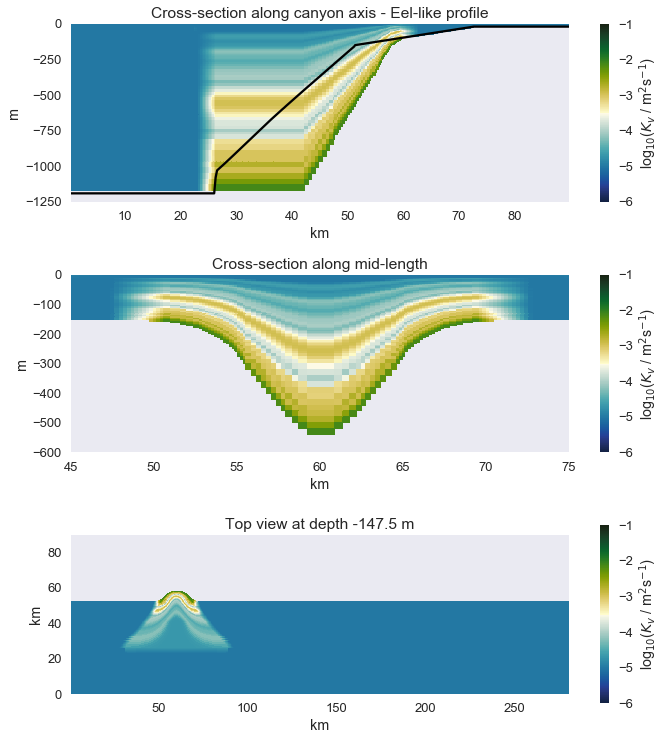

In [54]:
kv_final_eel[0:10,0:60,:] = 1e-5
fig, ax1, ax2, ax3 = plot_sections(kv_final_eel, 'Eel')
#fig.savefig('model_kv_from_Eel.eps', format='eps', bbox_inches='tight', frameon = False)

#### Maps referenced to rim and bottom 

In [91]:
kv_final_mty_rim = final_3D_diff(hFacCcan, kv_bg, delta, thresh, RC, kv_mty, dep_mty_rim, W=13000, kbg = 1e-5, rim_log=True)
print('done with Monterey')

kv_final_eel_rim = final_3D_diff(hFacCcan, kv_bg, delta, thresh, RC, kv_eel, dep_eel_rim, W=13000, kbg = 1e-5, rim_log=True)
print('done with Eel')

done with Eel


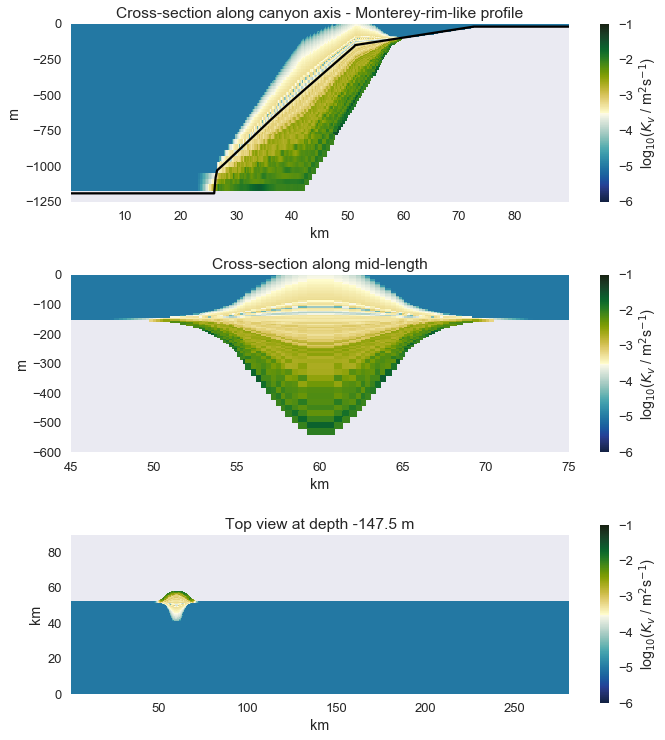

In [49]:
fig, ax1, ax2, ax3 = plot_sections(kv_final_mty_rim, 'Monterey-rim')

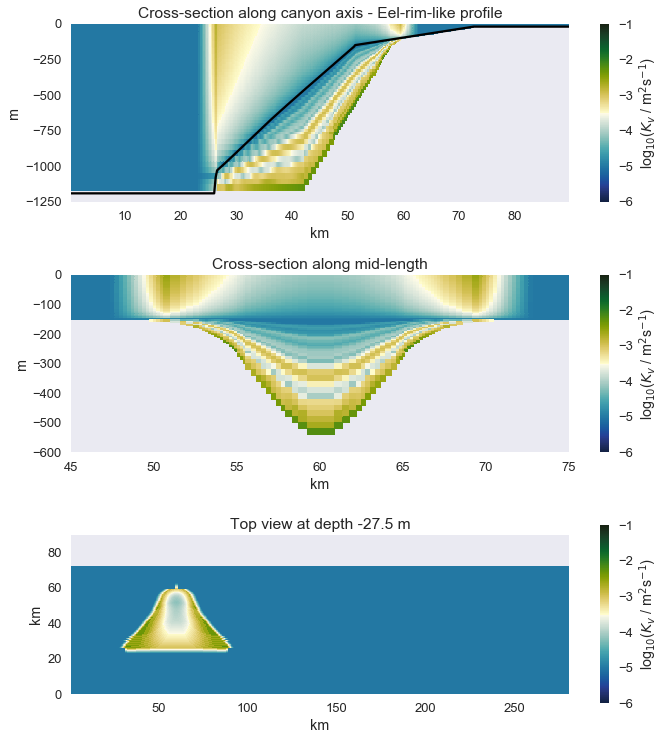

In [92]:
fig, ax1, ax2, ax3 = plot_sections(kv_final_eel_rim, 'Eel-rim')

In [93]:
# smooth out Eel profile - regions where rim is close to bottom exaggerate the difusivity near the surface. The mean profile shows an increase in diffusivity 
# but i don't think the green parts above de rim make much sense, I'll cut the max at kv = 10^4.

for ind in ind_canyon:
    bot_ind = np.argmin(hFacC[:,ind[0],ind[1]]) # find bottom z-index (first zero in hFacC)
    if bot_ind == 0: # this means hfac=1 through the whole water col
        bot_ind = 89
    rim_ind = np.argmin(hFacC[:,ind[0],280]) # find rim z-index 
    kv_final_eel_rim[:rim_ind,ind[0], ind[1]] = np.where(kv_final_eel_rim[:rim_ind,ind[0], ind[1]]>1E-4, 1E-4,
                                                     kv_final_eel_rim[:rim_ind,ind[0], ind[1]])


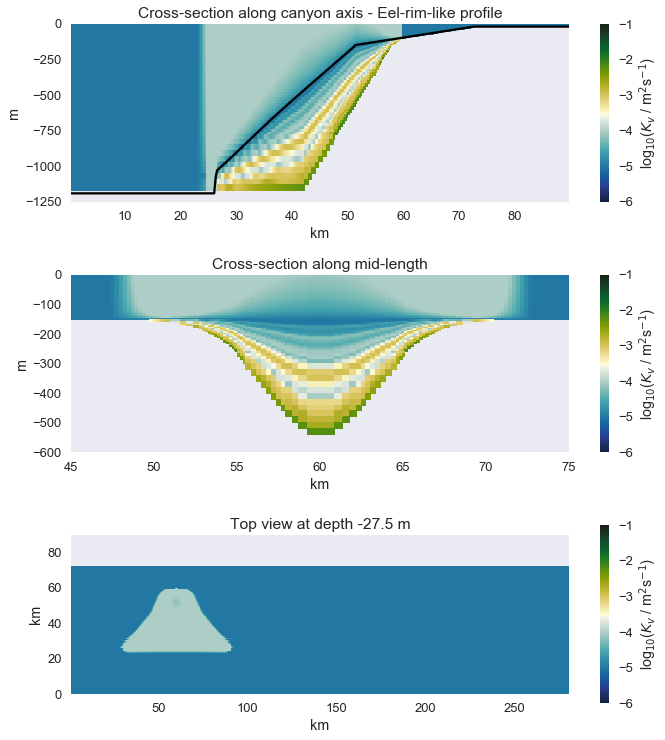

In [98]:
kv_final_eel_rim[:,68:74,55:305] = 1E-4 
kv_final_eel_rim[:,269:290,172:187] = 1E-5 
fig, ax1, ax2, ax3 = plot_sections(kv_final_eel_rim, 'Eel-rim')

## Check that I used the right indices
#ax1.axvline(Y[74]/1000, color='k')
#ax1.axvline(Y[68]/1000, color='k')
#ax1.axvline(Y[269]/1000,color='k')
#ax1.axvline(Y[274]/1000,color='k')
#ax3.axvline(X[55]/1000,color='k')
#ax3.axvline(X[305]/1000,color='k')

In [99]:
# save binary files

dt = np.dtype('>f8')  # float 64 big endian
fileobj = open(filename,mode='wb')
kv_final_mty.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename2,mode='wb')
kv_final_eel.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename_rim,mode='wb')
kv_final_mty_rim.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename2_rim,mode='wb')
kv_final_eel_rim.astype(dt).tofile(fileobj,"")
fileobj.close()


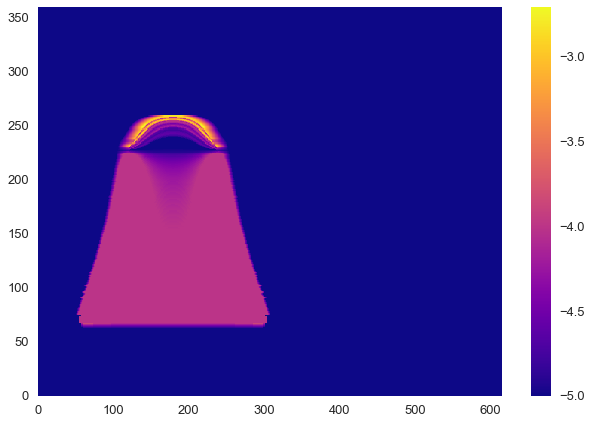

In [100]:
# Check that the values of the file are in the right order 

dt = np.dtype('>f8')  # float 64 big endian

fileNAME = filename2_rim
kv=np.fromfile(fileNAME, dt)

Kv=np.reshape(kv,(nz,ny,nx),order='C')
np.shape(Kv)

plt.pcolor(np.log10(Kv[29,:,:]), cmap='plasma')
plt.colorbar()
